# Modele:

Dla każdego z 3 konceptów (pelikany, flamingi, gęsi) mamy dane przepuszczone już przez pipeline (CLIP+SAE). Chcemy na nich zbudować 3 proste modele:

1) zbudowany tylko na neuronie odpowiedzialnym za koncept, który chcemy wykrywać,

2) zbudowany na wszystkich neuronach,

3) zbudowany na neuronach z największą sumą wartości dla zdjęć z danym konceptem.

Następnie porównamy te trzy podejścia w celu sprawdzenia, czy patrząc tylko na jeden neuron, który powinien być opdowiedzialny za dany koncept, jesteśmy w stanie zbudować model, który będzie dobrze decydował o tym, czy na danym zdjęciu znajduje się ten koncept. Poza tym porównamy wagi neuronów dla modelu zbudowanego na wszystkich neuronach i sprawdzimy, jakim konceptom one odpowiadają według pliku clip_ViT-L_14concept_names.csv. Pokaże to, które neurony i koncepty najbardziej decydują o tym, czy dany koncept jest obecny na zdjęciu.

## Wczytanie danych.

In [1444]:
import pandas as pd

# Załaduj plik CSV z nazwami konceptów
concept_df = pd.read_csv("../data/clip_ViT-L_14concept_names.csv",  header=None, names=["neuron_index", "concept_name"])
concept_df["neuron_index"] = concept_df["neuron_index"].astype(int)


In [1445]:
import torch

# Pelikany
X_pelican = torch.load("../data/X_concepts_pelican.pt")
y_pelican = torch.load("../data/y_labels_pelican.pt")

print(X_pelican.shape)
print(y_pelican.shape)

# Flamingi
X_flamingo = torch.load("../data/X_concepts_flamingo.pt")
y_flamingo = torch.load("../data/y_labels_flamingo.pt")

print(X_flamingo.shape)
print(y_flamingo.shape)

# Gęsi
X_goose = torch.load("../data/X_concepts_goose.pt")
y_goose = torch.load("../data/y_labels_goose.pt")

print(X_goose.shape)
print(y_goose.shape)


torch.Size([400, 6144])
torch.Size([400])
torch.Size([400, 6144])
torch.Size([400])
torch.Size([400, 6144])
torch.Size([400])


Sprawdźmy, ile dla danego konceptu jest danych z tym konceptem, a ile bez (czy dane są zbalansowane: powinny być, bo braliśmy wcześniej po 200 zdjęć z każdego konceptu, ale dla upewnienia).

In [1446]:
with_pelicans = (y_pelican == 1).sum().item()
wo_pelicans = (y_pelican == 0).sum().item()

print(f"Liczba danych ze zbioru pelikanów z pelikanami (X_pelican): {with_pelicans}")
print(f"Liczba danych bez pelikanów ze zbioru pelikanów (X_pelican): {wo_pelicans}\n")

with_flamingos = (y_flamingo == 1).sum().item()
wo_flamingos = (y_flamingo == 0).sum().item()

print(f"Liczba danych ze zbioru flamingów z flamingami (X_flamingo): {with_flamingos}")
print(f"Liczba danych bez flamingów ze zbioru flamingów (X_flamingo): {wo_flamingos}\n")

with_geese = (y_goose == 1).sum().item()
wo_geese = (y_goose == 0).sum().item()

print(f"Liczba danych ze zbioru gęsi z gęsiami (X_goose): {with_geese}")
print(f"Liczba danych bez gęsi ze zbioru gęsi (X_goose): {wo_geese}\n")

Liczba danych ze zbioru pelikanów z pelikanami (X_pelican): 200
Liczba danych bez pelikanów ze zbioru pelikanów (X_pelican): 200

Liczba danych ze zbioru flamingów z flamingami (X_flamingo): 200
Liczba danych bez flamingów ze zbioru flamingów (X_flamingo): 200

Liczba danych ze zbioru gęsi z gęsiami (X_goose): 200
Liczba danych bez gęsi ze zbioru gęsi (X_goose): 200



## Modele dla zbioru pelikanów.

In [1447]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

Przykłady zdjęć za zbioru:

In [1448]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

def image_print(dataset_path, concept_name, nr_img=3):
    '''
    Function to display example images from a dataset for a given concept.
    Parameters:
        dataset_path - path to the dataset with images
        concept_name - name of the concept, e.g. "pelican"
        nr_img - number of images to display per class
    '''
    example_images = {0: [], 1: []}

    for label_dir in ["0_other", f"1_{concept_name}"]:
        label = 0 if label_dir == "0_other" else 1
        dir_path = Path(dataset_path) / label_dir
        image_paths = [p for p in dir_path.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        example_images[label] = image_paths[:nr_img]

    # Wyświetlanie obrazów
    print(f"\nPrzykładowe obrazy dla zbioru {concept_name} (po {nr_img} na klasę):")
    fig, axes = plt.subplots(2, nr_img, figsize=(4 * nr_img, 4))
    for label in [0, 1]:
        for i, img_path in enumerate(example_images[label]):
            img = Image.open(img_path)
            axes[label][i].imshow(img)
            axes[label][i].set_title(f"Label {label}, {concept_name}" if label == 1 else f"Label {label}, Inne")
            axes[label][i].axis("off")
    plt.tight_layout()
    plt.show()



Przykładowe obrazy dla zbioru pelican (po 5 na klasę):


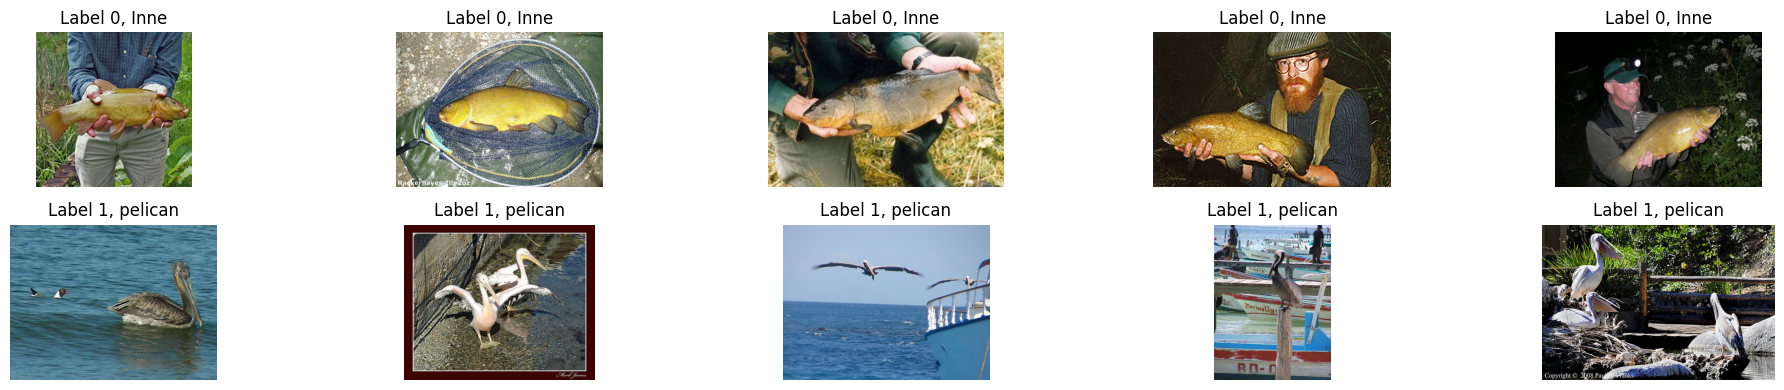

In [1449]:
image_print("../concept_datasets/binary_dataset_pelican", "pelican", 5)

Podział danych na testowe i treningowe.

In [1450]:
# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X_pelican, y_pelican, test_size=0.2, stratify=y_pelican, random_state=42)

# neuron dla "pelican"
pelican_neuron = concept_df.loc[concept_df["concept_name"] == "pelican", "neuron_index"].values[0]
print(f"Neuron index dla pelikana: {pelican_neuron}")

Neuron index dla pelikana: 1085


Sprawdźmy wartości dla neuronu, który w teorii powinien odpowiadaać za koncept pelikana.

In [1451]:
X_train[y_train == 0, pelican_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1452]:
X_train[y_train == 1, pelican_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Coś się nie zgadza - sprawdźmy, czy nie jest to przypadkiem zły neuron. Może jakiś inny neuron mówi nam więcej o tym, czy pelikan jest obecny na zdjęciu. Poszukujamy takiego, dla którego suma wartości neuronów dla zdjęć z pelikanami jest największa.

In [1453]:
import numpy as np

# Sumy aktywacji po kolumnach (neurony) tylko dla przykładów z y=1
sums_with = X_train[y_train == 1].sum(axis=0)

# Sumy po kolumnach z przykaldow bez pelikanow
sums_wo = X_train[y_train == 0].sum(axis=0)

# Indeks neuronu o najwyższej sumie
max_index = np.argmax(sums_with)
max_index = int(np.argmax(sums_with))

name_max_index = concept_df.loc[concept_df['neuron_index'] == max_index, 'concept_name'].values
name_1085 = concept_df.loc[concept_df['neuron_index'] == pelican_neuron, 'concept_name'].values

# Bezpieczne wypisanie (zabezpieczenie, gdyby brakowało w CSV)
name_max_index = name_max_index[0] if len(name_max_index) > 0 else "brak w pliku"
name_1085 = name_1085[0] if len(name_1085) > 0 else "brak w pliku"

# Wypisanie informacji
print(f"Neuron z najwyższą sumą aktywacji dla zdjęć z pelikanami: {max_index} ({name_max_index})\n")
print(f"Suma wartości tego neuronu dla zdjęć z pelikanami: {sums_with[max_index]}")
print(f"Suma wartości tego neuronu dla zdjęć bez pelikanów: {sums_wo[max_index]}\n")
print(f"Neuron z konceptem pelikana wg autorów: {pelican_neuron} ({name_1085})\n")
print(f"Suma wartości tego neuronu dla zdjęć z pelikanami: {sums_with[pelican_neuron]}")
print(f"Suma wartości tego neuronu dla zdjęć bez pelikanów: {sums_wo[pelican_neuron]}")


Neuron z najwyższą sumą aktywacji dla zdjęć z pelikanami: 111 (birds)

Suma wartości tego neuronu dla zdjęć z pelikanami: 748.2510986328125
Suma wartości tego neuronu dla zdjęć bez pelikanów: 266.2774353027344

Neuron z konceptem pelikana wg autorów: 1085 (pelican)

Suma wartości tego neuronu dla zdjęć z pelikanami: 0.0
Suma wartości tego neuronu dla zdjęć bez pelikanów: 0.0


Zobaczmy, jak wyglądają wartości neuronu odpowiadającego za koncept 'birds'.

In [1454]:
X_train[y_train == 0, 111]

tensor([0.0000, 1.1120, 4.2199, 1.1682, 1.1223, 0.1907, 0.7005, 0.6303, 0.4905,
        0.0000, 0.1484, 5.6731, 0.5801, 0.3283, 0.3541, 0.2391, 0.6215, 0.0000,
        0.6891, 5.2362, 0.3435, 0.2528, 0.4170, 0.0000, 0.0000, 0.0000, 0.7363,
        0.0000, 1.4463, 5.7929, 0.4367, 0.0000, 4.7334, 0.0854, 0.0000, 4.8739,
        0.3427, 0.0000, 0.3132, 1.3885, 1.3202, 0.5010, 4.4508, 1.7178, 0.0000,
        0.9700, 0.2841, 5.6986, 0.9745, 4.7263, 0.4672, 0.0000, 1.0944, 0.1951,
        2.5009, 3.7908, 0.9070, 0.0000, 0.0219, 1.4890, 3.9711, 0.8972, 0.0771,
        1.9473, 4.8973, 5.2224, 0.0429, 0.0000, 1.6894, 1.4184, 4.8445, 0.3620,
        0.1401, 1.8411, 0.0000, 4.5752, 0.7314, 0.0000, 5.3931, 4.8907, 1.2875,
        5.4297, 5.3211, 0.9916, 1.2021, 4.6208, 5.0872, 0.8224, 1.9143, 1.4994,
        1.0189, 0.6252, 0.4549, 0.1927, 0.7361, 4.9892, 0.9449, 6.0994, 0.0000,
        0.0086, 4.8314, 0.0000, 4.7440, 0.2613, 0.0000, 0.0377, 4.1159, 0.3147,
        0.8690, 0.0000, 0.6592, 0.2449, 

In [1455]:
X_train[y_train == 1, 111]

tensor([4.7937, 4.8129, 5.5702, 5.0952, 4.1034, 4.9550, 4.5728, 3.5800, 5.2656,
        4.5237, 5.4848, 4.8634, 4.9187, 4.8093, 3.7721, 4.5295, 4.5737, 4.2526,
        4.0558, 4.7318, 4.7386, 5.2141, 5.3047, 4.9631, 4.0349, 5.3726, 5.7222,
        4.1159, 4.7866, 4.1084, 4.6997, 4.9584, 4.7285, 5.1554, 5.2639, 5.0703,
        5.4352, 4.8604, 4.6480, 4.9353, 5.4228, 5.5191, 4.8642, 4.8221, 4.8656,
        4.8986, 5.5939, 4.0814, 4.9940, 5.0489, 4.8668, 4.5827, 5.0706, 4.6171,
        5.0728, 4.9306, 5.3915, 5.3038, 5.2583, 5.2578, 3.9793, 5.0702, 4.7605,
        4.3923, 4.4375, 4.2072, 4.9728, 4.7340, 4.6938, 4.3595, 3.3883, 4.3686,
        4.5433, 4.7742, 4.7632, 4.4706, 3.9150, 4.6783, 4.8172, 4.6018, 3.5131,
        4.3222, 4.5202, 5.0122, 4.4618, 4.2244, 5.2573, 4.1716, 4.0892, 4.2365,
        4.4026, 4.6962, 5.1281, 4.2950, 4.1275, 4.5719, 5.0115, 3.4847, 5.3574,
        4.8737, 4.4896, 4.6843, 5.2600, 5.0605, 4.4088, 4.8249, 4.8969, 4.9513,
        4.2810, 4.8959, 5.3959, 5.2887, 

Model liniowy na neuronie odpowiadającym za koncept pelikana:

In [1456]:
# Model na neuronie 1085
X_train_single = X_train[:, pelican_neuron].reshape(-1, 1)
X_test_single = X_test[:, pelican_neuron].reshape(-1, 1)
clf_single = LogisticRegression().fit(X_train_single, y_train)
preds_single = clf_single.predict(X_test_single)
acc_single = accuracy_score(y_test, preds_single)
roc_single = roc_auc_score(y_test, clf_single.predict_proba(X_test_single)[:, 1])
zero_weights_single = np.sum(clf_single.coef_ == 0)

Regresja logistyczna dla wszystkich neuronów (szukamy takich parametrów c dla l1, gdzie jest jak największe sparsity ale ROC jest około 0.99):

In [1457]:
# Model na pełnym wektorze, sprawdzenie kilku wartości C
C_values = [1, 0.1, 0.01, 0.005, 0.001]
C_values.extend(np.linspace(0.1, 0.01, 22))  # Zawężenie zakresu C w miejscach, które są blisko ROC=0.99
results = []

for C in C_values:
    clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    clf_l1.fit(X_train, y_train)

    roc = roc_auc_score(y_test, clf_l1.predict_proba(X_test)[:, 1])
    zero_weights = np.sum(clf_l1.coef_ == 0)
    total_weights = clf_l1.coef_.shape[1]
    sparsity = zero_weights / total_weights

    print(f"C={C} | ROC AUC={roc:.4f} | Sparsity={sparsity:.4f} ({zero_weights}/{total_weights})")

C=1 | ROC AUC=0.9963 | Sparsity=0.9954 (6116/6144)
C=0.1 | ROC AUC=0.9944 | Sparsity=0.9980 (6132/6144)
C=0.01 | ROC AUC=0.8694 | Sparsity=0.9997 (6142/6144)
C=0.005 | ROC AUC=0.7744 | Sparsity=0.9998 (6143/6144)
C=0.001 | ROC AUC=0.5000 | Sparsity=1.0000 (6144/6144)
C=0.1 | ROC AUC=0.9944 | Sparsity=0.9980 (6132/6144)
C=0.09571428571428572 | ROC AUC=0.9944 | Sparsity=0.9980 (6132/6144)
C=0.09142857142857143 | ROC AUC=0.9944 | Sparsity=0.9980 (6132/6144)
C=0.08714285714285715 | ROC AUC=0.9950 | Sparsity=0.9980 (6132/6144)
C=0.08285714285714287 | ROC AUC=0.9956 | Sparsity=0.9980 (6132/6144)
C=0.07857142857142857 | ROC AUC=0.9962 | Sparsity=0.9980 (6132/6144)
C=0.07428571428571429 | ROC AUC=0.9969 | Sparsity=0.9980 (6132/6144)
C=0.07 | ROC AUC=0.9981 | Sparsity=0.9980 (6132/6144)
C=0.06571428571428573 | ROC AUC=0.9981 | Sparsity=0.9982 (6133/6144)
C=0.06142857142857143 | ROC AUC=0.9981 | Sparsity=0.9984 (6134/6144)
C=0.05714285714285715 | ROC AUC=0.9975 | Sparsity=0.9984 (6134/6144)
C=0.

Wybieramy C=0.04 | ROC AUC=0.9900 | Sparsity=0.9987 (6136/6144)

In [1458]:
# model
clf_full = LogisticRegression(penalty="l1", solver="liblinear", C=0.04, max_iter=1000).fit(X_train, y_train)
preds_full = clf_full.predict(X_test)
acc_full = accuracy_score(y_test, preds_full)
roc_full = roc_auc_score(y_test, clf_full.predict_proba(X_test)[:, 1])
zero_weights_full = np.sum(clf_full.coef_ == 0)

Model zbudowany na neuronach z największą sumą wartości dla zdjęć z danym konceptem (znajdźmy te neurony).

In [1459]:
# Suma wartości dla każdego neuronu tylko na danych z pelikanami
pel_sum = X_pelican[y_pelican == 1].sum(dim=0)
# Neurony o największej sumie aktywacji
top_k = torch.topk(pel_sum, k=5)
top_neurons = top_k.indices.tolist()


print("Top aktywne neurony (pelikan):", top_neurons)

print("\nNazwy konceptów dla top 5 neuronów:")
for idx in top_neurons:
    row = concept_df.loc[concept_df["neuron_index"] == idx]
    name = row["concept_name"].values[0] if not row.empty else "brak w pliku"
    print(f"Neuron {idx}: {name}")


Top aktywne neurony (pelikan): [111, 1019, 3986, 352, 3318]

Nazwy konceptów dla top 5 neuronów:
Neuron 111: birds
Neuron 1019: wildlife
Neuron 3986: pic
Neuron 352: canoeing
Neuron 3318: beach


In [1460]:
# Podział danych
X_top = X_pelican[:, top_neurons]
X_train, X_test, y_train, y_test = train_test_split(X_top, y_pelican, test_size=0.2, stratify=y_pelican, random_state=42)

# Trening modelu
clf_top = LogisticRegression(max_iter=1000)
clf_top.fit(X_train, y_train)
preds = clf_top.predict(X_test)

# Ocena
acc_top = accuracy_score(y_test, preds)
roc_top = roc_auc_score(y_test, clf_top.predict_proba(X_test)[:, 1])
zero_weights_top = np.sum(clf_top.coef_ == 0)

## Wyniki dla zbioru pelikanów:

In [1461]:
pelican_results = {
    "logistic_regression_full": {"accuracy": acc_full, "roc_auc": roc_full, "zero_weights": zero_weights_full, "sparsity": zero_weights_full / clf_full.coef_.shape[1]},
    "naming_neuron_1085": {"accuracy": acc_single, "roc_auc": roc_single, "zero_weights": zero_weights_single, "sparsity": zero_weights_single / clf_single.coef_.shape[1]},
    "top_5_neurons": {"accuracy": acc_top, "roc_auc": roc_top, "zero_weights": zero_weights_top, "sparsity": zero_weights_top / clf_top.coef_.shape[1]}
}

In [1462]:
print(f"Pelican results: {pelican_results}")

Pelican results: {'logistic_regression_full': {'accuracy': 0.9, 'roc_auc': 0.99, 'zero_weights': 6136, 'sparsity': 0.9986979166666666}, 'naming_neuron_1085': {'accuracy': 0.5, 'roc_auc': 0.5, 'zero_weights': 1, 'sparsity': 1.0}, 'top_5_neurons': {'accuracy': 0.9375, 'roc_auc': 0.935625, 'zero_weights': 0, 'sparsity': 0.0}}


In [1463]:
results_df_pelican = pd.DataFrame.from_dict({
    "Logistic Regression (full vector)": pelican_results["logistic_regression_full"],
    "Neuron 1085 (pelican)": pelican_results["naming_neuron_1085"],
    "Top 5 Neurons": pelican_results["top_5_neurons"]
}, orient="index")

display(results_df_pelican)

,accuracy,roc_auc,zero_weights,sparsity
Logistic Regression (full vector),0.9000,0.990000,6136,0.998698
Neuron 1085 (pelican),0.5000,0.500000,1,1.000000
Top 5 Neurons,0.9375,0.935625,0,0.000000


## Porównanie wag neuronów dla modelu zbudowanego na wszystkich neuronach.

In [1464]:
top_weights = clf_full.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Top 10 neuronów według wag modelu:")
for idx in top_weights[:10]:
    # Znajdź nazwę konceptu
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")

Top 10 neuronów według wag modelu:
Neuron 111, Waga: 0.3158, Koncept: birds
Neuron 352, Waga: 0.2795, Koncept: canoeing
Neuron 3318, Waga: 0.0230, Koncept: beach
Neuron 6143, Waga: 0.0000, Koncept: collar
Neuron 2051, Waga: 0.0000, Koncept: lynx
Neuron 2043, Waga: 0.0000, Koncept: affirm
Neuron 2044, Waga: 0.0000, Koncept: vast
Neuron 2045, Waga: 0.0000, Koncept: sennheiser
Neuron 2046, Waga: 0.0000, Koncept: bricks
Neuron 2047, Waga: 0.0000, Koncept: managers


In [1465]:
print("\nBottom 10 neuronów według wag modelu:")
for idx in top_weights[-10:]:
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")



Bottom 10 neuronów według wag modelu:
Neuron 4099, Waga: 0.0000, Koncept: pile
Neuron 4100, Waga: 0.0000, Koncept: flea
Neuron 4101, Waga: 0.0000, Koncept: iu
Neuron 4102, Waga: 0.0000, Koncept: ufo
Neuron 0, Waga: 0.0000, Koncept: lendingtree
Neuron 316, Waga: -0.0140, Koncept: dvd
Neuron 2766, Waga: -0.1574, Koncept: underwater
Neuron 548, Waga: -0.1899, Koncept: turtles
Neuron 5685, Waga: -0.5963, Koncept: hare
Neuron 6111, Waga: -0.6348, Koncept: juvenile


In [1466]:
# 3. Wypisz wagę neuronu klasy
weight_pelikan = clf_full.coef_[0][pelican_neuron]
pelican_name_match = concept_df.loc[concept_df['neuron_index'] == pelican_neuron, 'concept_name']
pelican_concept_name = pelican_name_match.values[0] if len(pelican_name_match) > 0 else "brak nazwy"

print(f"Neuron przypisany do klasy 'pelican': {pelican_neuron}")
print(f"  → Waga w modelu: {weight_pelikan:.4f}")
print(f"  → Nazwa konceptu: {pelican_concept_name}")

# 4. Znajdź neuron o najwyższej wadze
top_idx = np.argmax(clf_full.coef_[0])
top_weight = clf_full.coef_[0][top_idx]
top_name_match = concept_df.loc[concept_df['neuron_index'] == top_idx, 'concept_name']
top_concept_name = top_name_match.values[0] if len(top_name_match) > 0 else "brak nazwy"

print(f"\nNeuron z największą wagą:")
print(f"  → Neuron: {top_idx}")
print(f"  → Waga: {top_weight:.4f}")
print(f"  → Nazwa konceptu: {top_concept_name}")

Neuron przypisany do klasy 'pelican': 1085
  → Waga w modelu: 0.0000
  → Nazwa konceptu: pelican

Neuron z największą wagą:
  → Neuron: 111
  → Waga: 0.3158
  → Nazwa konceptu: birds


## Porównanie wag neuronów dla modelu zbudowanego na neuronach z najwyższą sumą dla zdjęc z pelikanami.

In [1467]:
top_weights = clf_top.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Wszystkie neurony według wag modelu:")
for local_idx in top_weights:
    global_idx = top_neurons[local_idx]  # oryginalny indeks neuronu
    match = concept_df.loc[concept_df['neuron_index'] == global_idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron (w concept names): {global_idx}, Neuron w tym modelu: {local_idx}, Waga: {clf_top.coef_[0][local_idx]:.4f}, Koncept: {concept_name}")

Wszystkie neurony według wag modelu:
Neuron (w concept names): 352, Neuron w tym modelu: 3, Waga: 1.6925, Koncept: canoeing
Neuron (w concept names): 3318, Neuron w tym modelu: 4, Waga: 1.6772, Koncept: beach
Neuron (w concept names): 111, Neuron w tym modelu: 0, Waga: 1.4003, Koncept: birds
Neuron (w concept names): 1019, Neuron w tym modelu: 1, Waga: 0.8460, Koncept: wildlife
Neuron (w concept names): 3986, Neuron w tym modelu: 2, Waga: -0.0586, Koncept: pic


## Modele dla zbioru flamingów.

Przykłady zdjęć ze zbioru:


Przykładowe obrazy dla zbioru flamingo (po 5 na klasę):


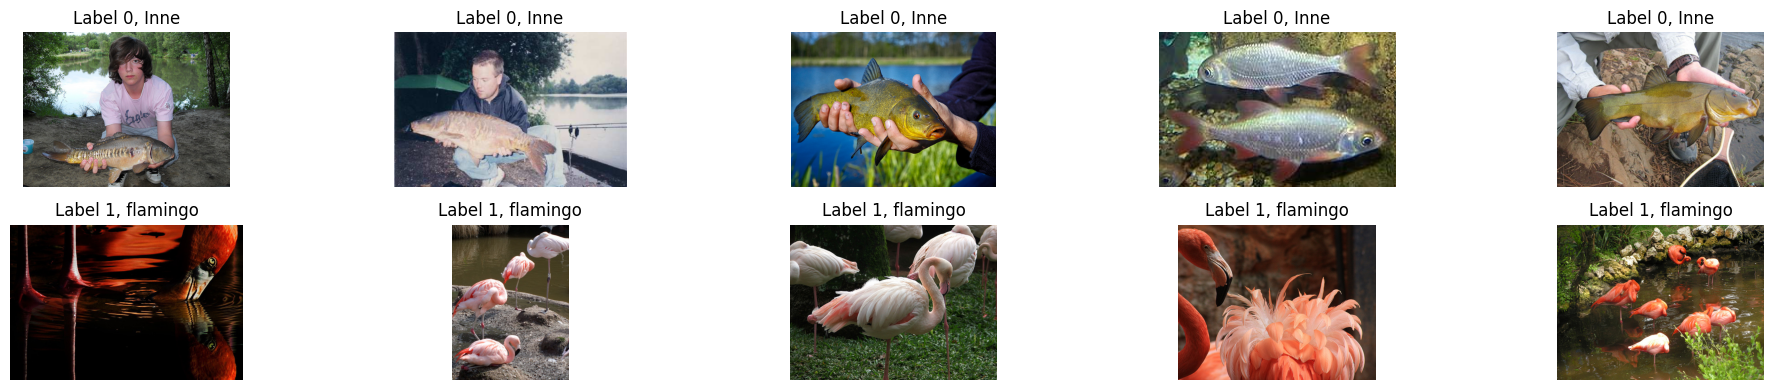

In [1468]:
image_print("../concept_datasets/binary_dataset_flamingos", "flamingo", 5)

Podział danych na testowe i treningowe.

In [1469]:
# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X_flamingo, y_flamingo, test_size=0.2, stratify=y_flamingo, random_state=42)

# neuron dla "flamingo"
flamingo_neuron = concept_df.loc[concept_df["concept_name"] == "flamingo", "neuron_index"].values[0]
print(f"Neuron index dla flaminga: {flamingo_neuron}")


Neuron index dla flaminga: 2347


Sprawdźmy wartości dla neuronu, który w teorii powinien odpowiadać za koncept flaminga.

In [1470]:
X_train[y_train == 1, flamingo_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1471]:
X_train[y_train == 0, flamingo_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Znowu same zera, poszukajmy dla którego neuronu suma wartości dla zdjęć z flamingiem jest największa.

In [1472]:
# Sumy aktywacji po kolumnach (neurony) tylko dla przykładów z y=1
sums_with = X_train[y_train == 1].sum(axis=0)

# Sumy po kolumnach z przykaldow bez pelikanow
sums_wo = X_train[y_train == 0].sum(axis=0)

# Indeks neuronu o najwyższej sumie
max_index = np.argmax(sums_with)
max_index = int(np.argmax(sums_with))

name_max_index = concept_df.loc[concept_df['neuron_index'] == max_index, 'concept_name'].values
name_2347 = concept_df.loc[concept_df['neuron_index'] == flamingo_neuron, 'concept_name'].values

# Bezpieczne wypisanie (zabezpieczenie, gdyby brakowało w CSV)
name_max_index = name_max_index[0] if len(name_max_index) > 0 else "brak w pliku"
name_2347 = name_2347[0] if len(name_2347) > 0 else "brak w pliku"

# Wypisanie informacji
print(f"Neuron z najwyższą sumą aktywacji dla zdjęć z flamingami: {max_index} ({name_max_index})\n")
print(f"Suma wartości tego neuronu dla zdjęć z flamingami: {sums_with[max_index]}")
print(f"Suma wartości tego neuronu dla zdjęć bez flamingów: {sums_wo[max_index]}\n")
print(f"Neuron z konceptem flaminga wg autorów: {flamingo_neuron} ({name_2347})\n")
print(f"Suma wartości tego neuronu dla zdjęć z flamingami: {sums_with[flamingo_neuron]}")
print(f"Suma wartości tego neuronu dla zdjęć bez flamingów: {sums_wo[flamingo_neuron]}")


Neuron z najwyższą sumą aktywacji dla zdjęć z flamingami: 111 (birds)

Suma wartości tego neuronu dla zdjęć z flamingami: 650.3216552734375
Suma wartości tego neuronu dla zdjęć bez flamingów: 343.5186462402344

Neuron z konceptem flaminga wg autorów: 2347 (flamingo)

Suma wartości tego neuronu dla zdjęć z flamingami: 0.0
Suma wartości tego neuronu dla zdjęć bez flamingów: 0.0


Model liniowy na neuronie odpowiadającym za koncept flaminga:

In [1473]:
# Model na pojedynczym neuronie
X_train_single = X_train[:, flamingo_neuron].reshape(-1, 1)
X_test_single = X_test[:, flamingo_neuron].reshape(-1, 1)
clf_single = LogisticRegression().fit(X_train_single, y_train)
preds_single = clf_single.predict(X_test_single)
acc_single = accuracy_score(y_test, preds_single)
roc_single = roc_auc_score(y_test, clf_single.predict_proba(X_test_single)[:, 1])
zero_weights_single = np.sum(clf_single.coef_ == 0)


Regresja logistyczna dla wszystkich neuronów (szukamy takich parametrów c dla l1, gdzie jest jak największe sparsity ale ROC jest około 0.99):

In [1474]:
# Model na pełnym wektorze, sprawdzenie kilku wartości C
C_values = [1, 0.1, 0.01, 0.005, 0.001]
C_values.extend(np.linspace(0.01, 0.005, 15))  # Zawężenie zakresu C w miejscach, które są blisko ROC=0.99
results = []

for C in C_values:
    clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    clf_l1.fit(X_train, y_train)

    roc = roc_auc_score(y_test, clf_l1.predict_proba(X_test)[:, 1])
    zero_weights = np.sum(clf_l1.coef_ == 0)
    total_weights = clf_l1.coef_.shape[1]
    sparsity = zero_weights / total_weights

    print(f"C={C} | ROC AUC={roc:.4f} | Sparsity={sparsity:.4f} ({zero_weights}/{total_weights})")

C=1 | ROC AUC=0.9981 | Sparsity=0.9971 (6126/6144)
C=0.1 | ROC AUC=0.9981 | Sparsity=0.9989 (6137/6144)
C=0.01 | ROC AUC=0.9969 | Sparsity=0.9997 (6142/6144)
C=0.005 | ROC AUC=0.5000 | Sparsity=1.0000 (6144/6144)
C=0.001 | ROC AUC=0.5000 | Sparsity=1.0000 (6144/6144)
C=0.01 | ROC AUC=0.9969 | Sparsity=0.9997 (6142/6144)
C=0.009642857142857142 | ROC AUC=0.9950 | Sparsity=0.9997 (6142/6144)
C=0.009285714285714286 | ROC AUC=0.9944 | Sparsity=0.9997 (6142/6144)
C=0.008928571428571428 | ROC AUC=0.9900 | Sparsity=0.9997 (6142/6144)
C=0.008571428571428572 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.008214285714285714 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.007857142857142858 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.0075 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.0071428571428571435 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.0067857142857142855 | ROC AUC=0.9881 | Sparsity=0.9998 (6143/6144)
C=0.006428571428571429 | ROC AUC=0.9881 | Sparsity=0.9998 (6

Wybieramy C=0.008928571428571428 | ROC AUC=0.9900 | Sparsity=0.9997 (6142/6144)

In [1475]:
# Wybrany finalny model na pełnym wektorze
clf_full = LogisticRegression(penalty="l1", C = 0.008928571428571428, solver="liblinear", max_iter=1000).fit(X_train, y_train)
preds_full = clf_full.predict(X_test)
acc_full = accuracy_score(y_test, preds_full)
zero_weights_full = np.sum(clf_full.coef_ == 0)
roc_full = roc_auc_score(y_test, clf_full.predict_proba(X_test)[:, 1])

Model zbudowany na neuronach z największą sumą wartości dla zdjęć z danym konceptem (znajdźmy te neurony).

In [1476]:
# Suma wartości dla każdego neuronu tylko na danych z flamingami
flam_sum = X_flamingo[y_flamingo == 1].sum(dim=0)
# Neurony o największej sumie aktywacji
top_k = torch.topk(flam_sum, k=5)
top_neurons = top_k.indices.tolist()


print("Top aktywne neurony (flaming):", top_neurons)

print("\nNazwy konceptów dla top 5 neuronów:")
for idx in top_neurons:
    row = concept_df.loc[concept_df["neuron_index"] == idx]
    name = row["concept_name"].values[0] if not row.empty else "brak w pliku"
    print(f"Neuron {idx}: {name}")


Top aktywne neurony (flaming): [111, 1019, 3986, 2842, 5108]

Nazwy konceptów dla top 5 neuronów:
Neuron 111: birds
Neuron 1019: wildlife
Neuron 3986: pic
Neuron 2842: pinkworld
Neuron 5108: banner


In [1477]:
# Podział danych
X_top = X_flamingo[:, top_neurons]
X_train, X_test, y_train, y_test = train_test_split(X_top, y_flamingo, test_size=0.2, stratify=y_flamingo, random_state=42)

# Trening modelu
clf_top = LogisticRegression(max_iter=1000)
clf_top.fit(X_train, y_train)
preds = clf_top.predict(X_test)

# Ocena
acc_top = accuracy_score(y_test, preds)
roc_top = roc_auc_score(y_test, clf_top.predict_proba(X_test)[:, 1])
zero_weights_top = np.sum(clf_top.coef_ == 0)

## Wyniki dla zbioru flamingów:

In [1478]:
results_flamingo = {
    "naming_neuron": {"accuracy": acc_single, "roc_auc": roc_single, "zero_weights": zero_weights_single, "sparsity": zero_weights_single / clf_single.coef_.shape[1]},
    "logistic_regression_full": {"accuracy": acc_full, "roc_auc": roc_full, "zero_weights": zero_weights_full, "sparsity": zero_weights_full / clf_full.coef_.shape[1]},
    "top_5_neurons": {"accuracy": acc_top, "roc_auc": roc_top, "zero_weights": zero_weights_top, "sparsity": zero_weights_top / clf_top.coef_.shape[1]}
}

In [1479]:
print(f"Flamingo results: {results_flamingo}")

Flamingo results: {'naming_neuron': {'accuracy': 0.5, 'roc_auc': 0.5, 'zero_weights': 1, 'sparsity': 1.0}, 'logistic_regression_full': {'accuracy': 0.6875, 'roc_auc': 0.99, 'zero_weights': 6142, 'sparsity': 0.9996744791666666}, 'top_5_neurons': {'accuracy': 0.975, 'roc_auc': 0.9981249999999999, 'zero_weights': 0, 'sparsity': 0.0}}


In [1480]:
results_df_flamingo = pd.DataFrame.from_dict({
    "Logistic Regression (full vector)": results_flamingo["logistic_regression_full"],
    "Neuron 1085 (flamingo)": results_flamingo["naming_neuron"],
    "Top 5 Neurons": results_flamingo["top_5_neurons"]
}, orient="index")

display(results_df_flamingo)

,accuracy,roc_auc,zero_weights,sparsity
Logistic Regression (full vector),0.6875,0.990000,6142,0.999674
Neuron 1085 (flamingo),0.5000,0.500000,1,1.000000
Top 5 Neurons,0.9750,0.998125,0,0.000000


## Porównanie wag neuronów dla modelu zbudowanego na wszystkich neuronach.

In [1481]:
top_weights = clf_full.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Top 10 neuronów według wag modelu:")
for idx in top_weights[:10]:
    # Znajdź nazwę konceptu
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")

Top 10 neuronów według wag modelu:
Neuron 2842, Waga: 0.2852, Koncept: pinkworld
Neuron 6143, Waga: 0.0000, Koncept: collar
Neuron 2050, Waga: 0.0000, Koncept: crate
Neuron 2041, Waga: 0.0000, Koncept: tulip
Neuron 2042, Waga: 0.0000, Koncept: battles
Neuron 2043, Waga: 0.0000, Koncept: affirm
Neuron 2044, Waga: 0.0000, Koncept: vast
Neuron 2045, Waga: 0.0000, Koncept: sennheiser
Neuron 2046, Waga: 0.0000, Koncept: bricks
Neuron 2047, Waga: 0.0000, Koncept: managers


In [1482]:
print("\nBottom 10 neuronów według wag modelu:")
for idx in top_weights[-10:]:
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")


Bottom 10 neuronów według wag modelu:
Neuron 4093, Waga: 0.0000, Koncept: zebra
Neuron 4094, Waga: 0.0000, Koncept: cookware
Neuron 4095, Waga: 0.0000, Koncept: drawing
Neuron 4096, Waga: 0.0000, Koncept: guestbook
Neuron 4097, Waga: 0.0000, Koncept: orioles
Neuron 4098, Waga: 0.0000, Koncept: jaguar
Neuron 4099, Waga: 0.0000, Koncept: pile
Neuron 4100, Waga: 0.0000, Koncept: flea
Neuron 0, Waga: 0.0000, Koncept: lendingtree
Neuron 6111, Waga: -0.0050, Koncept: juvenile


In [1483]:
# Wypisz wagę neuronu klasy
weight_flamingo = clf_full.coef_[0][flamingo_neuron]
flamingo_name_match = concept_df.loc[concept_df['neuron_index'] == flamingo_neuron, 'concept_name']
flamingo_concept_name = flamingo_name_match.values[0] if len(flamingo_name_match) > 0 else "brak nazwy"

print(f"Neuron przypisany do klasy 'flamingo': {flamingo_neuron}")
print(f"  → Waga w modelu: {weight_flamingo:.4f}")
print(f"  → Nazwa konceptu: {flamingo_concept_name}")

# Znajdź neuron o najwyższej wadze
top_idx = np.argmax(clf_full.coef_[0])
top_weight = clf_full.coef_[0][top_idx]
top_name_match = concept_df.loc[concept_df['neuron_index'] == top_idx, 'concept_name']
top_concept_name = top_name_match.values[0] if len(top_name_match) > 0 else "brak nazwy"

print(f"\nNeuron z największą wagą:")
print(f"  → Neuron: {top_idx}")
print(f"  → Waga: {top_weight:.4f}")
print(f"  → Nazwa konceptu: {top_concept_name}")

Neuron przypisany do klasy 'flamingo': 2347
  → Waga w modelu: 0.0000
  → Nazwa konceptu: flamingo

Neuron z największą wagą:
  → Neuron: 2842
  → Waga: 0.2852
  → Nazwa konceptu: pinkworld


## Porównanie wag neuronów dla modelu zbudowanego na neuronach z najwyższą sumą dla zdjęc z pelikanami.

In [1484]:
top_weights = clf_top.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Wszystkie neurony według wag modelu:")
for local_idx in top_weights:
    global_idx = top_neurons[local_idx]  # oryginalny indeks neuronu
    match = concept_df.loc[concept_df['neuron_index'] == global_idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron (w concept names): {global_idx}, Neuron w tym modelu: {local_idx}, Waga: {clf_top.coef_[0][local_idx]:.4f}, Koncept: {concept_name}")

Wszystkie neurony według wag modelu:
Neuron (w concept names): 2842, Neuron w tym modelu: 3, Waga: 3.3412, Koncept: pinkworld
Neuron (w concept names): 1019, Neuron w tym modelu: 1, Waga: 0.6896, Koncept: wildlife
Neuron (w concept names): 111, Neuron w tym modelu: 0, Waga: 0.5055, Koncept: birds
Neuron (w concept names): 3986, Neuron w tym modelu: 2, Waga: 0.1954, Koncept: pic
Neuron (w concept names): 5108, Neuron w tym modelu: 4, Waga: -0.1805, Koncept: banner


## Modele dla zbioru gęsi.

Przykłady zdjęć ze zbioru:


Przykładowe obrazy dla zbioru goose (po 5 na klasę):


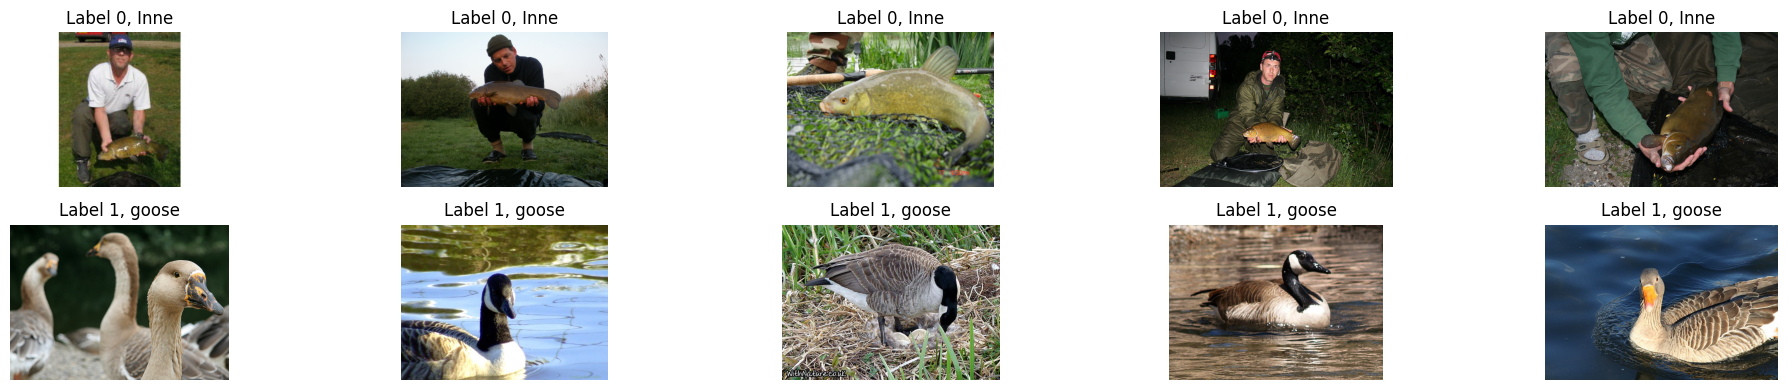

In [1485]:
image_print("../concept_datasets/binary_dataset_geese", "goose", 5)

Podział danych na testowe i treningowe.

In [1486]:
# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X_goose, y_goose, test_size=0.2, stratify=y_goose, random_state=42)

# neuron dla "goose"
goose_neuron = concept_df.loc[concept_df["concept_name"] == "goose", "neuron_index"].values[0]
print(f"Neuron index dla gęsi: {goose_neuron}")

Neuron index dla gęsi: 3426


Sprawdźmy wartości dla neuronu, który w teorii powinien odpowiadać za koncept gęsi.

In [1487]:
X_train[y_train == 1, goose_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1488]:
X_train[y_train == 0, goose_neuron]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Dziwne, ale znowu same zera. Poszukajmy dla którego neuronu suma wartości dla zdjęć z gęsiami jest największa.

In [1489]:
# Sumy aktywacji po kolumnach (neurony) tylko dla przykładów z y=1
sums_with = X_train[y_train == 1].sum(axis=0)
sums_wo = X_train[y_train == 0].sum(axis=0)
# Indeks neuronu o najwyższej sumie
max_index = np.argmax(sums_with)
max_index = int(np.argmax(sums_with))

# Pobranie nazw konceptów
name_max_index = concept_df.loc[concept_df['neuron_index'] == max_index, 'concept_name'].values
name_3426 = concept_df.loc[concept_df['neuron_index'] == goose_neuron, 'concept_name'].values

# Bezpieczne wypisanie (zabezpieczenie, gdyby brakowało w CSV)
name_max_index = name_max_index[0] if len(name_max_index) > 0 else "brak w pliku"
name_3426 = name_3426[0] if len(name_3426) > 0 else "brak w pliku"

# Wypisanie wyników
print(f"Neuron z najwyższą sumą aktywacji dla zdjęć z gęsiami: {max_index} ({name_max_index})")
print(f"Suma wartości tego neuronu dla zdjęć z gęsiami: {sums_with[max_index]}")
print(f"Suma wartości tego neuronu dla zdjęć bez gęsi: {sums_wo[max_index]}\n")

print(f"Neuron z konceptem gęsi wg autorów: {goose_neuron} ({name_3426})")
print(f"Suma wartości tego neuronu dla zdjęć z gęsiami: {sums_with[goose_neuron]}")
print(f"Suma wartości tego neuronu dla zdjęć bez gęsi: {sums_wo[goose_neuron]}")


Neuron z najwyższą sumą aktywacji dla zdjęć z gęsiami: 111 (birds)
Suma wartości tego neuronu dla zdjęć z gęsiami: 755.861083984375
Suma wartości tego neuronu dla zdjęć bez gęsi: 295.38323974609375

Neuron z konceptem gęsi wg autorów: 3426 (goose)
Suma wartości tego neuronu dla zdjęć z gęsiami: 0.0
Suma wartości tego neuronu dla zdjęć bez gęsi: 0.0


Znowu ptaki, czego można było się spodziewać.

Model liniowy na neuronie odpowiadającym za koncept gęsi:

In [1490]:
# Model na pojedynczym neuronie
X_train_single = X_train[:, goose_neuron].reshape(-1, 1)
X_test_single = X_test[:, goose_neuron].reshape(-1, 1)
clf_single = LogisticRegression().fit(X_train_single, y_train)
preds_single = clf_single.predict(X_test_single)
acc_single = accuracy_score(y_test, preds_single)
roc_single = roc_auc_score(y_test, clf_single.predict_proba(X_test_single)[:, 1])
zero_weights_single = np.sum(clf_single.coef_ == 0)

Regresja logistyczna dla wszystkich neuronów:

In [1491]:
# Model na pełnym wektorze, sprawdzenie kilku wartości C
C_values = [1, 0.1, 0.01, 0.005, 0.001]
C_values.extend(np.linspace(0.1, 0.001, 22))  # Zawężenie zakresu C w miejscach, które są blisko ROC=0.99
results = []

for C in C_values:
    clf_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    clf_l1.fit(X_train, y_train)

    roc = roc_auc_score(y_test, clf_l1.predict_proba(X_test)[:, 1])
    zero_weights = np.sum(clf_l1.coef_ == 0)
    total_weights = clf_l1.coef_.shape[1]
    sparsity = zero_weights / total_weights

    print(f"C={C} | ROC AUC={roc:.4f} | Sparsity={sparsity:.4f} ({zero_weights}/{total_weights})")

C=1 | ROC AUC=1.0000 | Sparsity=0.9956 (6117/6144)
C=0.1 | ROC AUC=1.0000 | Sparsity=0.9979 (6131/6144)


C=0.01 | ROC AUC=0.9750 | Sparsity=0.9995 (6141/6144)
C=0.005 | ROC AUC=0.8700 | Sparsity=0.9998 (6143/6144)
C=0.001 | ROC AUC=0.5000 | Sparsity=1.0000 (6144/6144)
C=0.1 | ROC AUC=1.0000 | Sparsity=0.9979 (6131/6144)
C=0.09528571428571429 | ROC AUC=1.0000 | Sparsity=0.9979 (6131/6144)
C=0.09057142857142858 | ROC AUC=1.0000 | Sparsity=0.9979 (6131/6144)
C=0.08585714285714287 | ROC AUC=1.0000 | Sparsity=0.9982 (6133/6144)
C=0.08114285714285716 | ROC AUC=1.0000 | Sparsity=0.9982 (6133/6144)
C=0.07642857142857143 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.07171428571428572 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.067 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.06228571428571429 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.05757142857142858 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.052857142857142866 | ROC AUC=1.0000 | Sparsity=0.9984 (6134/6144)
C=0.04814285714285715 | ROC AUC=1.0000 | Sparsity=0.9985 (6135/6144)
C=0.043428571428571434 | ROC AUC=0.99

Wybieramy C=0.01042857142857144 | ROC AUC=0.9906 | Sparsity=0.9995 (6141/6144)

In [1492]:
# Model na pełnym wektorze
clf_full = LogisticRegression(penalty="l1", solver="liblinear", C = 0.01042857142857144, max_iter=1000).fit(X_train, y_train)
preds_full = clf_full.predict(X_test)
acc_full = accuracy_score(y_test, preds_full)
roc_full = roc_auc_score(y_test, clf_full.predict_proba(X_test)[:, 1])
zero_weights_full = np.sum(clf_full.coef_ == 0)

Model zbudowany na neuronach z największą sumą wartości dla zdjęć z danym konceptem (znajdźmy te neurony).

In [1493]:
# Suma wartości dla każdego neuronu tylko na danych z gęsiami
goose_sum = X_goose[y_goose == 1].sum(dim=0)
# Neurony o największej sumie aktywacji
top_k = torch.topk(goose_sum, k=5)
top_neurons = top_k.indices.tolist()


print("Top aktywne neurony (goose):", top_neurons)

print("\nNazwy konceptów dla top 5 neuronów:")
for idx in top_neurons:
    row = concept_df.loc[concept_df["neuron_index"] == idx]
    name = row["concept_name"].values[0] if not row.empty else "brak w pliku"
    print(f"Neuron {idx}: {name}")


Top aktywne neurony (goose): [111, 3986, 352, 1019, 184]

Nazwy konceptów dla top 5 neuronów:
Neuron 111: birds
Neuron 3986: pic
Neuron 352: canoeing
Neuron 1019: wildlife
Neuron 184: audi


In [1494]:
# Podział danych
X_top = X_goose[:, top_neurons]
X_train, X_test, y_train, y_test = train_test_split(X_top, y_goose, test_size=0.2, stratify=y_goose, random_state=42)

# Trening modelu
clf_top = LogisticRegression(max_iter=1000)
clf_top.fit(X_train, y_train)
preds = clf_top.predict(X_test)

# Ocena
acc_top = accuracy_score(y_test, preds)
roc_top = roc_auc_score(y_test, clf_top.predict_proba(X_test)[:, 1])
zero_weights_top = np.sum(clf_top.coef_ == 0)

## Wyniki dla zbioru gęsi:

In [1495]:
results_goose = {
    "naming_neuron": {"accuracy": acc_single, "roc_auc": roc_single, "zero_weights": zero_weights_single, "sparsity": zero_weights_single / clf_single.coef_.shape[1]},
    "logistic_regression_full": {"accuracy": acc_full, "roc_auc": roc_full, "zero_weights": zero_weights_full, "sparsity": zero_weights_full / clf_full.coef_.shape[1]},
    "top_5_neurons": {"accuracy": acc_top, "roc_auc": roc_top, "zero_weights": zero_weights_top, "sparsity": zero_weights_top / clf_top.coef_.shape[1]}
}

In [1496]:
print(f"Goose results: {results_goose}")

Goose results: {'naming_neuron': {'accuracy': 0.5, 'roc_auc': 0.5, 'zero_weights': 1, 'sparsity': 1.0}, 'logistic_regression_full': {'accuracy': 0.775, 'roc_auc': 0.990625, 'zero_weights': 6141, 'sparsity': 0.99951171875}, 'top_5_neurons': {'accuracy': 0.975, 'roc_auc': 1.0, 'zero_weights': 0, 'sparsity': 0.0}}


In [1497]:
results_df_goose = pd.DataFrame.from_dict({
    "Logistic Regression (full vector)": results_goose["logistic_regression_full"],
    "Neuron 1085 (goose)": results_goose["naming_neuron"],
    "Top 5 Neurons": results_goose["top_5_neurons"]
}, orient="index")

display(results_df_goose)

,accuracy,roc_auc,zero_weights,sparsity
Logistic Regression (full vector),0.775,0.990625,6141,0.999512
Neuron 1085 (goose),0.500,0.500000,1,1.000000
Top 5 Neurons,0.975,1.000000,0,0.000000


## Porównanie wag neuronów dla modelu zbudowanego na wszystkich neuronach.

In [1498]:
# Wypisz wagę neuronu klasy
weight_goose = clf_full.coef_[0][goose_neuron]
goose_name_match = concept_df.loc[concept_df['neuron_index'] == goose_neuron, 'concept_name']
goose_concept_name = goose_name_match.values[0] if len(goose_name_match) > 0 else "brak nazwy"

print(f"Neuron przypisany do klasy 'goose': {goose_neuron}")
print(f"  → Waga w modelu: {weight_goose:.4f}")
print(f"  → Nazwa konceptu: {goose_concept_name}")

# Znajdź neuron o najwyższej wadze
top_idx = np.argmax(clf_full.coef_[0])
top_weight = clf_full.coef_[0][top_idx]
top_name_match = concept_df.loc[concept_df['neuron_index'] == top_idx, 'concept_name']
top_concept_name = top_name_match.values[0] if len(top_name_match) > 0 else "brak nazwy"

print(f"\nNeuron z największą wagą:")
print(f"  → Neuron: {top_idx}")
print(f"  → Waga: {top_weight:.4f}")
print(f"  → Nazwa konceptu: {top_concept_name}")

Neuron przypisany do klasy 'goose': 3426
  → Waga w modelu: 0.0000
  → Nazwa konceptu: goose

Neuron z największą wagą:
  → Neuron: 111
  → Waga: 0.0917
  → Nazwa konceptu: birds


In [1499]:
top_weights = clf_full.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Top 10 neuronów według wag modelu:")
for idx in top_weights[:10]:
    # Znajdź nazwę konceptu
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")

Top 10 neuronów według wag modelu:
Neuron 111, Waga: 0.0917, Koncept: birds
Neuron 352, Waga: 0.0886, Koncept: canoeing
Neuron 6143, Waga: 0.0000, Koncept: collar
Neuron 2051, Waga: 0.0000, Koncept: lynx
Neuron 2043, Waga: 0.0000, Koncept: affirm
Neuron 2044, Waga: 0.0000, Koncept: vast
Neuron 2045, Waga: 0.0000, Koncept: sennheiser
Neuron 2046, Waga: 0.0000, Koncept: bricks
Neuron 2047, Waga: 0.0000, Koncept: managers
Neuron 2048, Waga: 0.0000, Koncept: ribbon


In [1500]:
print("\nBottom 10 neuronów według wag modelu:")
for idx in top_weights[-10:]:
    match = concept_df.loc[concept_df['neuron_index'] == idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron {idx}, Waga: {clf_full.coef_[0][idx]:.4f}, Koncept: {concept_name}")


Bottom 10 neuronów według wag modelu:
Neuron 4093, Waga: 0.0000, Koncept: zebra
Neuron 4094, Waga: 0.0000, Koncept: cookware
Neuron 4095, Waga: 0.0000, Koncept: drawing
Neuron 4096, Waga: 0.0000, Koncept: guestbook
Neuron 4097, Waga: 0.0000, Koncept: orioles
Neuron 4098, Waga: 0.0000, Koncept: jaguar
Neuron 4099, Waga: 0.0000, Koncept: pile
Neuron 4100, Waga: 0.0000, Koncept: flea
Neuron 0, Waga: 0.0000, Koncept: lendingtree
Neuron 548, Waga: -0.1336, Koncept: turtles


## Porównanie wag neuronów dla modelu zbudowanego na neuronach z najwyższą sumą dla zdjęć z gęsiami.

In [1501]:
top_weights = clf_top.coef_[0].argsort()[::-1]

# Wyświetl 10 neuronów z najwyższą wagą + ich nazwy
print("Wszystkie neurony według wag modelu:")
for local_idx in top_weights:
    global_idx = top_neurons[local_idx]  # oryginalny indeks neuronu
    match = concept_df.loc[concept_df['neuron_index'] == global_idx, 'concept_name']
    concept_name = match.values[0] if len(match) > 0 else "brak nazwy"

    print(f"Neuron (w concept names): {global_idx}, Neuron w tym modelu: {local_idx}, Waga: {clf_top.coef_[0][local_idx]:.4f}, Koncept: {concept_name}")

Wszystkie neurony według wag modelu:
Neuron (w concept names): 184, Neuron w tym modelu: 4, Waga: 2.2035, Koncept: audi
Neuron (w concept names): 352, Neuron w tym modelu: 2, Waga: 1.5191, Koncept: canoeing
Neuron (w concept names): 111, Neuron w tym modelu: 0, Waga: 1.1843, Koncept: birds
Neuron (w concept names): 3986, Neuron w tym modelu: 1, Waga: 0.0146, Koncept: pic
Neuron (w concept names): 1019, Neuron w tym modelu: 3, Waga: -0.9996, Koncept: wildlife
